# Toy Linear Regression

In [1]:
import numpy as np
from caffe2.python import core, workspace as ws, model_helper, brew, optimizer as optim, net_drawer
import datagen
from dataclasses import dataclass
from torch.utils.data import DataLoader

In [2]:
from IPython import display

In [3]:
trainset, valset, testset = datagen.regression(n_samples=100_000)
print(len(trainset), len(valset), len(testset))

70000 20000 10000


In [4]:
def build_model():
    model = model_helper.ModelHelper("linreg")
    z1 = brew.fc(model, "X", "z1", dim_in=5, dim_out=3, weight_init=("XavierFill", {}))
    a1 = brew.relu(model, "z1", "a1")
    y_hat = brew.fc(model, "a1", "y_hat", dim_in=3, dim_out=1, weight_init=("XavierFill", {}))
    return model

In [5]:
@dataclass
class Hyperparams:
    n_epochs: int
    lr: float
    batch_size: int

In [6]:
m = build_model()

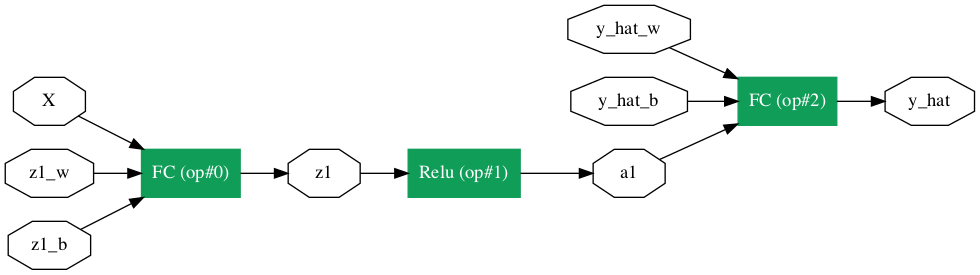

In [7]:
g = net_drawer.GetPydotGraph(m.net, rankdir="LR")
display.Image(g.create_png(), width=800)

In [8]:
from collections import namedtuple

In [9]:
TrainerArgs = namedtuple("TrainerArgs", ["model", "trainloader", "n_epochs"])

In [10]:
def build_trainer(hparams, trainset):
    linreg = build_model()
    dist = linreg.SquaredL2Distance(["y", "y_hat"], "dist")
    loss = linreg.AveragedLoss(dist, "loss")
    linreg.AddGradientOperators([loss])
    optim.build_adam(linreg, base_learning_rate=hparams.lr)
    traindl = DataLoader(trainset, batch_size=hparams.batch_size, shuffle=True)
    return TrainerArgs(
        model=linreg,
        trainloader=traindl,
        n_epochs=hparams.n_epochs
    )

In [11]:
def train(args):
    ws.ResetWorkspace()
    
    ws.RunNetOnce(args.model.param_init_net)
    
    tmp_x, tmp_y = next(iter(args.trainloader))
    tmp_x = tmp_x.numpy()
    tmp_y = tmp_y.numpy().reshape(-1, 1)
    ws.FeedBlob("X", tmp_x)
    ws.FeedBlob("y", tmp_y)
    ws.CreateNet(args.model.net)
    
    for epoch in range(args.n_epochs):
        batch_losses = []
        for batch_x, batch_y in args.trainloader:
            batch_x = batch_x.numpy()
            batch_y = batch_y.numpy().reshape(-1, 1)
            
            ws.FeedBlob("X", batch_x)
            ws.FeedBlob("y", batch_y)
            ws.RunNet(args.model.net)
            
            batch_loss = ws.FetchBlob("loss").item()
            batch_losses.append(batch_loss)
        
        epoch_loss = np.average(batch_losses)
        print(f"Epoch {epoch}: Loss = {epoch_loss:.3f}")

In [12]:
hparams = Hyperparams(batch_size=16, n_epochs=10, lr=0.03)
args = build_trainer(hparams, trainset)
train(args)

Epoch 0: Loss = 275.517
Epoch 1: Loss = 0.176
Epoch 2: Loss = 0.254
Epoch 3: Loss = 0.249
Epoch 4: Loss = 0.244
Epoch 5: Loss = 0.252
Epoch 6: Loss = 0.241
Epoch 7: Loss = 0.250
Epoch 8: Loss = 0.245
Epoch 9: Loss = 0.244


In [ ]:
ws.FetchBlob("z1_w")

In [ ]:
ws.FetchBlob("z1_b")

In [ ]:
ws.FetchBlob("y_hat_w")

In [ ]:
ws.FetchBlob("y_hat_b")